# Character Recognition

Eksperimen yang dilakukan adalah melakuakn kombinasi antara CTPN dan Tesseract. CTPN digunakan untuk mendapatkan bounding box yang berisi prediksi posisi text. Tesseract berfungsi sebagai character recognizer. Sebelum gambar diolah Tesseract, dilakukan preproses terlebhi dahulu agar meningkatkan akurasi. Ide eksperimen ini mirip dengan ide Faster RCNN yang terdiri dari RPN dan Fast-CNN.

## CTPN

sumber inspirasi: 
- https://arxiv.org/abs/1609.03605
- https://github.com/eragonruan/text-detection-ctpn

In [1]:
from __future__ import print_function

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import gfile

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

from lib.fast_rcnn.config import cfg, cfg_from_file
from lib.fast_rcnn.test import _get_blobs
from lib.text_connector.detectors import TextDetector
from lib.text_connector.text_connect_cfg import Config as TextLineCfg
from lib.rpn_msr.proposal_layer_tf import proposal_layer

def resize_im(im, scale, max_scale=None):
    f = float(scale) / min(im.shape[0], im.shape[1])
    if max_scale != None and f * max(im.shape[0], im.shape[1]) > max_scale:
        f = float(max_scale) / max(im.shape[0], im.shape[1])
    return cv2.resize(im, None, None, fx=f, fy=f, interpolation=cv2.INTER_LINEAR), f


def draw_boxes(img, image_name, boxes, scale, bbox):
    for box in boxes:
        if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3] - box[0]) < 5:
            continue
        if box[8] >= 0.9:
            color = (0, 255, 0)
        elif box[8] >= 0.8:
            color = (255, 0, 0)
        cv2.line(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
        cv2.line(img, (int(box[0]), int(box[1])), (int(box[4]), int(box[5])), color, 2)
        cv2.line(img, (int(box[6]), int(box[7])), (int(box[2]), int(box[3])), color, 2)
        cv2.line(img, (int(box[4]), int(box[5])), (int(box[6]), int(box[7])), color, 2)

        min_x = min(int(box[0] / scale), int(box[2] / scale), int(box[4] / scale), int(box[6] / scale))
        min_y = min(int(box[1] / scale), int(box[3] / scale), int(box[5] / scale), int(box[7] / scale))
        max_x = max(int(box[0] / scale), int(box[2] / scale), int(box[4] / scale), int(box[6] / scale))
        max_y = max(int(box[1] / scale), int(box[3] / scale), int(box[5] / scale), int(box[7] / scale))
        
        bbox.append([min_x, min_y, max_x, max_y])

    img = cv2.resize(img, None, None, fx=1.0 / scale, fy=1.0 / scale, interpolation=cv2.INTER_LINEAR)

/home/mhilmiasyrofi/tensorflow-cpu/venv/local/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/home/mhilmiasyrofi/tensorflow-cpu/venv/local/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:165: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/home/mhilmiasyrofi/tensorflow-cpu/venv/local/lib/python2.7/site-packages/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._tools import csgraph_to_dense, csgraph_from_dense,\
/home/mhilmiasyrofi/tensorflow-cpu/venv/local/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:167: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from

In [2]:
cfg_from_file('ctpn/text.yml')

# init session
config = tf.ConfigProto(allow_soft_placement=True)
sess = tf.Session(config=config)
with gfile.FastGFile('data/ctpn.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
sess.run(tf.global_variables_initializer())

input_img = sess.graph.get_tensor_by_name('Placeholder:0')
output_cls_prob = sess.graph.get_tensor_by_name('Reshape_2:0')
output_box_pred = sess.graph.get_tensor_by_name('rpn_bbox_pred/Reshape_1:0')

In [75]:
im_name = "data/demo/kemeja1764.jpg"
img = cv2.imread(im_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, scale = resize_im(img, scale=TextLineCfg.SCALE, max_scale=TextLineCfg.MAX_SCALE)
blobs, im_scales = _get_blobs(img, None)
if cfg.TEST.HAS_RPN:
    im_blob = blobs['data']
    blobs['im_info'] = np.array(
        [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
        dtype=np.float32)
cls_prob, box_pred = sess.run([output_cls_prob, output_box_pred], feed_dict={input_img: blobs['data']})
rois, _ = proposal_layer(cls_prob, box_pred, blobs['im_info'], 'TEST', anchor_scales=cfg.ANCHOR_SCALES)

scores = rois[:, 0]
boxes = rois[:, 1:5] / im_scales[0]
textdetector = TextDetector()
boxes = textdetector.detect(boxes, scores[:, np.newaxis], img.shape[:2])
bbox = []
draw_boxes(img, im_name, boxes, scale, bbox)

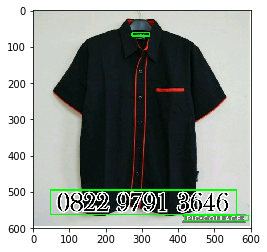

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline  

# draw image
plt.figure()
plt.imshow(img)

# cv2.imwrite("image", img)

In [77]:
imgs = []
img = cv2.imread(im_name)
for b in bbox :
    y1 = int(b[0]) 
    y2 = int(b[2]) 
    x1 = int(b[1]) 
    x2 = int(b[3]) 
    crop_img = img[x1:x2, y1:y2]
#     crop_img = cv2.resize(crop_img, None, fx = 2, fy = 2.4, interpolation = cv2.INTER_CUBIC)
    # gaussian_3 = cv2.GaussianBlur(crop_img, (9,9), 10.0)
    # unsharp_image = cv2.addWeighted(crop_img, 1.5, gaussian_3, -0.5, 0, crop_img)

    # blurred_f = ndimage.gaussian_filter(crop_img, 3)
    # filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)
    # alpha = 5
    # sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)
    imgs.append(crop_img)

In [6]:
# ga tahu kenapa di notebook ada beberapa warna yang berubah

# for i in imgs :
#     plt.figure()
#     plt.imshow(i)

## Tesseract

### Without processing

In [7]:
import pandas as pd
import tesserocr
from PIL import Image

In [8]:
# print(tesserocr.tesseract_version())  # print tesseract-ocr version
# print(tesserocr.get_languages())  # prints tessdata path and list of available languages

texts = []

# for img in imgs :
#     fig = plt.figure()
#     ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
#     img = Image.fromarray(img)
#     text = tesserocr.image_to_text(img)  # print ocr text from image
#     title = "Result: " + text
#     ax1.set_title(title)
#     plt.imshow(img)
#     texts.append(text)
    


### Resampling

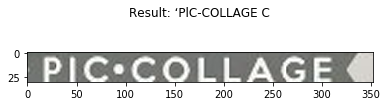

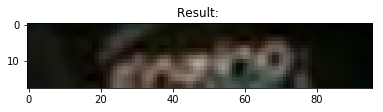

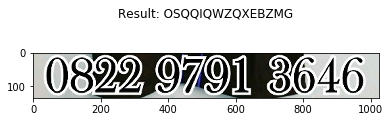

In [9]:
imgs_copy = imgs
for img in imgs_copy :
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    img = Image.fromarray(img)
    text = tesserocr.image_to_text(img)  # print ocr text from image
    title = "Result: " + text
    ax1.set_title(title)
    plt.imshow(img)


### Resampling  + Unsharp

In [10]:
# imgs_copy = imgs
# for img in imgs_copy :
#     fig = plt.figure()
#     ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
#     img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
#     gaussian_3 = cv2.GaussianBlur(img, (9,9), 10.0)
#     unsharp_image = cv2.addWeighted(img, 1.5, gaussian_3, -0.5, 0, img)
#     img = Image.fromarray(img)
#     text = tesserocr.image_to_text(img)  # print ocr text from image
#     title = "Result: " + text
#     ax1.set_title(title)
#     plt.imshow(img)


### Otsu Binarization

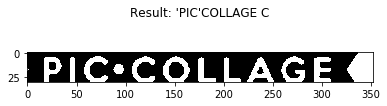

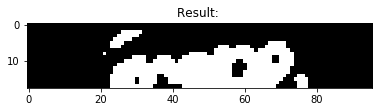

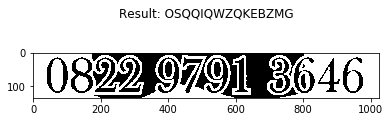

In [11]:
texts = []
imgs_copy = imgs
for img in imgs_copy :
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     img = cv2.bitwise_not(img)
    img = Image.fromarray(img)
    text = tesserocr.image_to_text(img)  # print ocr text from image
    title = "Result: " + text
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax1.set_title(title)
    plt.imshow(img)
    
    texts.append(text)

### Median Blur

In [18]:
# imgs_copy = imgs
# for img in imgs_copy :
#     fig = plt.figure()
#     ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
#     img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# #     img = cv2.bitwise_not(img)
#     img = cv2.medianBlur(img, 5)
#     img = Image.fromarray(img)
#     text = tesserocr.image_to_text(img)  # print ocr text from image
#     title = "Result: " + text
#     ax1.set_title(title)
#     plt.imshow(img)

# PyOCR
A Python wrapper for OCR engines (Tesseract, Cuneiform, etc)

In [45]:
import pyocr
import pyocr.builders

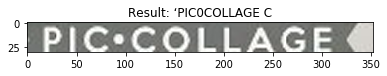

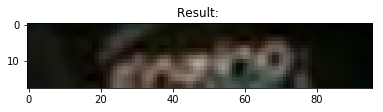

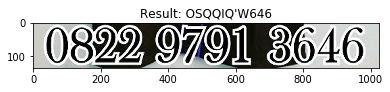

In [46]:
imgs_copy = imgs
tool = pyocr.get_available_tools()[0]
builder = pyocr.builders.TextBuilder()

for img in imgs_copy :
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    img = Image.fromarray(img)
    text = tool.image_to_string(
        img,
        lang='eng',
        builder=builder
    )
    title = "Result: " + text
    ax1.set_title(title)
    plt.imshow(img)


### Binarisation

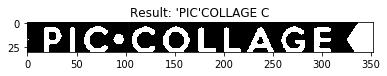

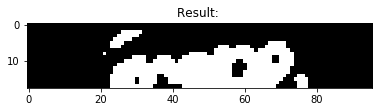

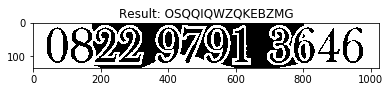

In [102]:
texts = []
imgs_copy = imgs
for img in imgs_copy :
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     img = cv2.bitwise_not(img)

    img = Image.fromarray(img)
    text = tool.image_to_string(
        img,
        lang='eng',
        builder=builder
    )
    title = "Result: " + text
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax1.set_title(title)
    plt.imshow(img)
    
    texts.append(text)

### Blob Preprocessing

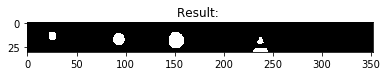

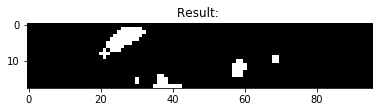

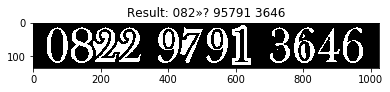

In [140]:
texts = []
imgs_copy = imgs
for img in imgs_copy :
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    img_raw = img
    cv2.imwrite("coba.jpg", img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img = cv2.bitwise_not(img)
    # Set up the detector with default parameters.
    
    _, contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    contour_outer = []
    contour_inner = []
#     print(contours)
#     print(hierarchy)
    max_idx = 0
    max_area = cv2.contourArea(contours[0])
    max_contour = contours[0]
    for i in range(1, len(contours)):
        area = cv2.contourArea(contours[i])
        if area > max_area :
            max_area = area
            max_idx = i
    for i in range(0, len(contours)):
        if i == max_idx :
            contour_outer.append(contours[i])
        else :
            contour_inner.append(contours[i])
#     cv2.drawContours(img_raw, contour_list,  -1, (255,0,0), 2)
    cv2.fillPoly(img, pts=contour_outer, color=(0))
    cv2.fillPoly(img, pts=contour_inner, color=(255))
    
    
    img = Image.fromarray(img)
    text = tool.image_to_string(
        img,
        lang='eng',
        builder=builder
    )
    title = "Result: " + text
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax1.set_title(title)
    plt.imshow(img)
    
#     plt.imshow(img_raw)
    
#     texts.append(text)

## Information Extraction

Pada tahap ini dilakukan eksperimen untuk mengetahui apakah di dalam text yang ada terdapat informasi seperti kontak HP, id bbm, id line, dll.

### Kontak HP

Deteksi dilakukan menggunakan regex

In [13]:
import re

def isContainHP(text) :
    text = text.encode("utf-8")
    # preprocess
    # remove some symbol
    text = text.translate(None, '-\'.() !@#')
    result = re.match("\d{10,12}|[+]\d{12,14}", text)
    if result :
        # print(result.group(0))
        return True
    else :
        return False

# print(texts)
# for t in texts :
#     print(isContainHP(t))

# Eksperimen Dengan Banyak Gambar

In [14]:
# import glob
# import os
# import shutil
# import sys

# print("Data dir :%s" % cfg.DATA_DIR)
# # im_names = glob.glob(os.path.join(cfg.DATA_DIR, 'fashion_bl', '*/*.png')) + \
# #             glob.glob(os.path.join(cfg.DATA_DIR, 'fashion_bl', '*/*.jpg'))

# im_names = glob.glob(os.path.join(cfg.DATA_DIR, 'fashion_bl', 'sample_polo_shirt/*.png')) + glob.glob(os.path.join(cfg.DATA_DIR, 'fashion_bl', 'sample_polo_shirt/*.jpg'))


# results = []

# for im_name in im_names:
#     img = cv2.imread(im_name)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img_copy = img
#     img, scale = resize_im(img, scale=TextLineCfg.SCALE, max_scale=TextLineCfg.MAX_SCALE)
#     blobs, im_scales = _get_blobs(img, None)
#     if cfg.TEST.HAS_RPN:
#         im_blob = blobs['data']
#         blobs['im_info'] = np.array(
#             [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
#             dtype=np.float32)
#     cls_prob, box_pred = sess.run([output_cls_prob, output_box_pred], feed_dict={input_img: blobs['data']})
#     rois, _ = proposal_layer(cls_prob, box_pred, blobs['im_info'], 'TEST', anchor_scales=cfg.ANCHOR_SCALES)

#     scores = rois[:, 0]
#     boxes = rois[:, 1:5] / im_scales[0]
#     textdetector = TextDetector()
#     boxes = textdetector.detect(boxes, scores[:, np.newaxis], img.shape[:2])
#     bbox = []
#     draw_boxes(img, im_name, boxes, scale, bbox)

#     texts = []

#     imgs = []

#     img = img_copy

#     for b in bbox :
#         y1 = int(b[0]) 
#         y2 = int(b[2]) 
#         x1 = int(b[1]) 
#         x2 = int(b[3]) 
#         crop_img = img[x1:x2, y1:y2]
#         imgs.append(crop_img)

#     for img in imgs :
#         img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#         img = Image.fromarray(img)
#         text = tesserocr.image_to_text(img)  # print ocr text from image
#         if isContainHP(text) :
#             results.append({"Image" : img, "Text" : text})
#         texts.append(text)
    
# print(len(results))
        

In [15]:
# print(results)

# for r in results :
#     fig = plt.figure()
#     ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
#     ax1.set_title(r["Text"])
#     plt.imshow(r["Image"])
    

## To Do List
- nyoba2 beberapa filter untuk kasus kata yang berdekatan. dikasih deskripsi kelebihan dan kekurangan untuk setiap eksperimen
- [DONE] validasi text melalui http request
- coba preprocessing dengan mencari blob, jika ada yang lebih dari 1/4 luas box, dihilangkan

### Validasi melalui akun media sosial

#### Twitter

In [16]:
import urllib2

def isValidUserTwitter(username) :

    url = "https://twitter.com/" + username
    try: 
        status = urllib2.urlopen(url).getcode()
    except urllib2.HTTPError as err:
        if err.code == 404:
    #         print("No User Found")
            status = 404
        else:
            raise
    return status == 200


username = "mhilmiasyrofi"
print(isValidUserTwitter(username))

True


#### Instagram

In [17]:
def isValidUserInstagram(username) :
    url = "https://www.instagram.com/" + username + "/"
    try: 
        status = urllib2.urlopen(url).getcode()
    except urllib2.HTTPError as err:
        if err.code == 404:
    #         print("No User Found")
            status = 404
        else:
            raise
    return status == 200
    
username = "avnusavas"
print(isValidUserInstagram(username))

False
